In [1]:
from image_dataset import create_dataloader
import torch.nn as nn
import torch.nn.functional as F
import torch
import transformers
import torch.optim as optim
from torchvision import transforms
from torchmetrics.functional.detection import intersection_over_union
from matplotlib.patches import Rectangle
import timm
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryAccuracy
import numpy as np

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:

class ResNetModel(nn.Module):
  def __init__(self, resnet_config, output_dim, anchor_size, device='cpu'):
    super(ResNetModel, self).__init__()
    self.baseline = transformers.ResNetModel(resnet_config).to(device)
    self.output_dim = output_dim
    self.anchor_size = anchor_size
    #self.lin1 = nn.Linear(resnet_config.hidden_sizes[-1],
    #                            1024,
    #                            device=device)
    self.lin1 = nn.Conv2d(resnet_config.hidden_sizes[-1],
                          out_channels=1024,
                          kernel_size=3,
                          stride=1,
                          padding=1,
                          device=device)
    self.output_rpn = nn.Linear(1024,
                                anchor_size,
                                device=device)

  def forward(self, x):
    last_hidden_state, _ = self.baseline(x, return_dict=False)
    #last_hidden_state = last_hidden_state.permute(0, 2, 3, 1)
    # last_hidden_state = output['last_hidden_state']
    x = self.lin1(last_hidden_state)
    x = F.gelu(x)
    x = x.permute(0, 2, 3, 1)
    rpn_output = self.output_rpn(x)
    return rpn_output, last_hidden_state

class InceptionModel(nn.Module):
  def __init__(self, output_dim, anchor_size, if_pretrained, device='cpu'):
    super(InceptionModel, self).__init__()
    model = timm.create_model('inception_v3', pretrained=if_pretrained).to(device)
    baseline = nn.Sequential(*list(model.children())[:-3])
    self.baseline = baseline
    self.output_dim = output_dim
    self.anchor_size = anchor_size
    self.lin1 = nn.Linear(2048,
                                1024,
                                device=device)
    self.output_rpn = nn.Linear(1024,
                                anchor_size,
                                device=device)

  def forward(self, x):
    last_hidden_state = self.baseline(x)
    last_hidden_state = last_hidden_state.permute(0, 2, 3, 1)
    # last_hidden_state = output['last_hidden_state']
    x = self.lin1(last_hidden_state)
    x = F.gelu(x)
    rpn_output = self.output_rpn(x)
    return rpn_output, last_hidden_state

def generate_anchors(anchor_sizes, anchor_ratios, new_size):
    anchors = []
    for size in anchor_sizes:
        for ratio in anchor_ratios:
            anchors.append((min(size, new_size[0]), 
                            min(size, new_size[1])))
            size1 = size * ratio
            size2 = size
            #if size1 < new_size[0] and size2 < new_size[1]:
            anchors.append((min(size1, new_size[0]), 
                            min(size2, new_size[1])))
            size1 = size
            size2 = size * ratio
            #if size1 < new_size[0] and size2 < new_size[1]:
            anchors.append((min(size1, new_size[0]), 
                            min(size2, new_size[1])))
    anchors.append(new_size)
    return torch.tensor(list(set(anchors)))

def generate_possible_anchors(shape, anchors, patch_size, new_size):
    '''
    test = generate_possible_anchors((4, 16, 16), anchors, patch_size, new_size)
    '''
    anchor_length = len(anchors)
    x_pom = torch.arange(shape[0])
    y_pom = torch.arange(shape[1])
    anchor_pom = torch.arange(anchor_length)

    tensor = torch.zeros(shape + (anchor_length, 4))
    tensor[x_pom, :, :, 0] = (x_pom * patch_size + patch_size / 2).view(1, shape[0], 1, 1)
    tensor[:, y_pom, :, 1] = (y_pom * patch_size + patch_size / 2).view(1, 1, shape[1], 1)
    tensor[:, :, anchor_pom, 0] -= anchors[:, 0] / 2
    tensor[:, :, anchor_pom, 1] -= anchors[:, 1] / 2
    tensor[:, :, anchor_pom, 2] = anchors[:, 0].to(torch.float)
    tensor[:, :, anchor_pom, 3] = anchors[:, 1].to(torch.float)
    tensor[:, :, :, 2] += tensor[:, :, :, 0].clip(-torch.inf, 0)
    tensor[:, :, :, 3] += tensor[:, :, :, 1].clip(-torch.inf, 0)
    tensor[:, :, :, 2] -= (tensor[:, :, :, 0] + tensor[:, :, :, 2] - float(new_size[0])).clip(0, torch.inf)
    tensor[:, :, :, 3] -= (tensor[:, :, :, 1] + tensor[:, :, :, 3] - float(new_size[1])).clip(0, torch.inf)
    tensor[..., :2] = tensor[..., :2].clip(0, 512)
    return tensor

def convert_bbox(tensor, type_from='xywh', type_to='xyxy'):
    tensor_copy = tensor.clone()
    if type_from == 'xywh' and type_to == 'xyxy':
        tensor_copy[..., 2:] += tensor_copy[..., :2]
    elif type_from == 'xyxy' and type_to == 'xywh':
        tensor_copy[..., 2:] -= tensor_copy[..., :2]
    return tensor_copy

def calculate_target_anchor_iou(anchors, bboxs, patch_size=0, lower_bound=0.3, upper_bound=0.9, approx=0.9):
    anchor_shape = anchors.shape
    ones_indices_list = []
    zeros_indices_list = []
    for x in bboxs:
        iou = intersection_over_union(anchors.view(-1, 4), x.unsqueeze(0), aggregate=False).view(anchor_shape[:-1])
        #area_part = torch.min(x[2] / patch_size, torch.tensor(1)) * torch.min(x[3] / patch_size, torch.tensor(1))
        quant = torch.quantile(iou, 1 - 2/iou.numel())
        #final_upper_bound = torch.max(quant, torch.tensor(upper_bound))
        final_upper_bound = min(quant, upper_bound) #upper_bound
        #final_upper_bound = torch.min(torch.tensor(upper_bound), area_part * upper_bound * approx)
        #index = (iou > final_upper_bound) | (iou < lower_bound) #| (lower_bound > final_upper_bound
        ones_indices_list.append((iou > final_upper_bound))
        zeros_indices_list.append((iou < min(lower_bound, final_upper_bound)))
    ones_tensor = torch.stack(ones_indices_list, dim=-1)
    ones_tensor = torch.max(ones_tensor, dim=-1)
    zeros_tensor = torch.stack(zeros_indices_list, dim=-1)
    zeros_tensor = torch.max(zeros_tensor, dim=-1)
    return ones_tensor.values, zeros_tensor.values

def generate_target_iou_per_anchor(anchors, bboxs, img_ids, batch_size):
    batch_ones = []
    batch_zeros = []
    for i in range(batch_size):
        bbox = bboxs[img_ids == i]
        ones, zeros = calculate_target_anchor_iou(anchors, bbox)
        batch_ones.append(ones)
        batch_zeros.append(zeros)
    return torch.stack(batch_ones, dim=0), torch.stack(batch_zeros, dim=0)

def print_log(rpn_output, epoch, step, loss, bboxs, image_data, ones, zeros, ones_output, zeros_output):
    pred_iou = F.sigmoid(rpn_output.detach()).cpu()
    print(f'Epoch: {epoch}, step: {step}, last loss: {loss.item()}, num_ex: {ones[0].sum()}, \
    max pred iou: {pred_iou[0].max().item()}, \
    mean pred iou: {pred_iou[0].mean().item()} \
    count highs: {(pred_iou[0]>0.9).sum()}')
    fig, axs = plt.subplots(1, 4, figsize=(12, 5))
    axs[0].plot(losses)
    axs[0].plot(calc_mov_average(losses))
    axs[1].hist(pred_iou[0].view(-1, 1).cpu(), bins=20)

    top_5_value = torch.quantile(pred_iou[0], 1-5/pred_iou[0].numel())
    chosen_anchors = (pred_iou[0]>min(0.99, top_5_value))
    #anchors_to_plot = possible_anchors[chosen_anchors]
    anchors_to_plot = nms(pred_iou[0][chosen_anchors], possible_anchors[chosen_anchors], treshold=0.5)
    axs[2].imshow(image_data[0].cpu().permute(1, 2, 0).clip(0, 1))
    max_i = 0
    for i, row in enumerate(anchors_to_plot):
        rect = Rectangle(row[:2], row[2], row[3], edgecolor=(0.73 * i % 1, 0.53 * i % 1, 0.37 * i % 1), facecolor='none', linewidth=1)
        axs[2].add_patch(rect)
        max_i += 1
        if max_i > 100:
            break
    axs[3].imshow(image_data[0].cpu().permute(1, 2, 0).clip(0, 1))
    max_i = 0
    bboxs_to_plot = possible_anchors[ones[0]]
    #bboxs_to_plot = bboxs[img_ids==0]
    for i, row in enumerate(bboxs_to_plot):
        rect = Rectangle(row[:2], row[2], row[3], edgecolor=(0.73 * i % 1, 0.53 * i % 1, 0.37 * i % 1), facecolor='none', linewidth=1)
        axs[3].add_patch(rect)
        max_i += 1
        if max_i > 100:
            break
    plt.show()
    plt.close()

def calc_mov_average(arr, window_len=300):
    # Handle edge case where window_len is greater than the length of the array
    if window_len <= 1:
        return arr  # No moving average needed if window length is 1 or less

    # Array to store the moving averages
    result = np.zeros_like(arr)

    # Loop over the array and compute the moving average
    for i in range(len(arr)):
        # Define the window start and end indices
        start = max(0, i - window_len + 1)
        end = i + 1

        # Compute the mean for the window, handles fewer elements than window_len
        result[i] = np.mean(arr[start:end])

    return result

def nms(preds, bboxs, treshold=0.5):
    #preds = pred_iou[0][chosen_anchors]
    #bboxs = possible_anchors[chosen_anchors]
    sorted_indices = preds.sort(descending=True).indices
    sorted_bboxs = convert_bbox(bboxs[sorted_indices])
    bboxs_to_print = []
    i = 0
    while len(sorted_bboxs) > 0 and i < 100:
        i += 1
        bbox = sorted_bboxs[0]
        bboxs_to_print.append(bbox)
        sorted_bboxs = sorted_bboxs[1:]
        if len(sorted_bboxs) > 1:
            ious = intersection_over_union(bbox.unsqueeze(0), sorted_bboxs, aggregate=False)
            kept_bboxs = (ious < treshold)[0]
            sorted_bboxs = sorted_bboxs[kept_bboxs]
    
    return convert_bbox(torch.stack(bboxs_to_print, dim=0), type_from='xyxy', type_to='xywh')

In [3]:

final_shape = 16
patch_size = 32
new_size = (512, 512)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: img.repeat(3//img.shape[0], 1, 1)),
    transforms.Resize(new_size),
                       ]
                              )
dataloader = create_dataloader(
    data_type = 'train',
    selected_categories = ['person', ],
    selected_output = ['bbox', ],
    new_size = new_size,
    patch_size = patch_size,
    transform = transform,
    batch_size = 32,
    #dataset_size = 1000
    )
'''
val_dataloader = create_dataloader(
    data_type = 'val',
    selected_categories = ['person', ],
    selected_output = ['bbox', ],
    new_size = new_size,
    patch_size = patch_size,
    transform = transform,
    batch_size = 32,
    #dataset_size = 1000
    )

val_iter = iter(val_dataloader)
'''

"\nval_dataloader = create_dataloader(\n    data_type = 'val',\n    selected_categories = ['person', ],\n    selected_output = ['bbox', ],\n    new_size = new_size,\n    patch_size = patch_size,\n    transform = transform,\n    batch_size = 32,\n    #dataset_size = 1000\n    )\n\nval_iter = iter(val_dataloader)\n"

In [4]:
anchor_sizes = [16, 32, 64, 128, 256]
anchor_ratios = [1, 2, 3/2, 5, 5/2, 4/3, 6/5, 4, 5/3]
anchors = generate_anchors(anchor_sizes, anchor_ratios, new_size=new_size)
print(anchors.shape, anchors[:5])

possible_anchors = generate_possible_anchors((final_shape, final_shape), anchors, patch_size, new_size)
possible_anchors.shape

torch.Size([78, 2]) tensor([[106.6667,  64.0000],
        [ 64.0000,  32.0000],
        [ 64.0000,  96.0000],
        [ 64.0000, 160.0000],
        [ 64.0000,  16.0000]])


torch.Size([16, 16, 78, 4])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_config = transformers.ResNetConfig(num_channels=3,
                                          #embedding_size=64,
                                          #hidden_sizes=(128, 256, 512, 1024, 2048),
                                          hidden_act='gelu',
                                          #depths = [3, 3, 3, 3, 3, 3],
                                          device = device)
model = ResNetModel(resnet_config,
                           output_dim=1,
                           anchor_size=len(anchors),
                           device = device)
'''
model = InceptionModel(output_dim=1,
                       anchor_size=len(anchors),
                       if_pretrained=False,
                       device = device)
'''
#for param in model.baseline.parameters():
#    param.requires_grad = False

'\nmodel = InceptionModel(output_dim=1,\n                       anchor_size=len(anchors),\n                       if_pretrained=False,\n                       device = device)\n'

In [6]:
loss_fn_rpn = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
scheduler = transformers.get_linear_schedule_with_warmup(optimizer=optimizer,
                                                                num_warmup_steps=3000,
                                                                num_training_steps=40000)

Epoch: 0, step: 14700, last loss: 0.1689736694097519, num_ex: 28,     max pred iou: 0.9920909404754639,     mean pred iou: 0.17688390612602234     count highs: 621


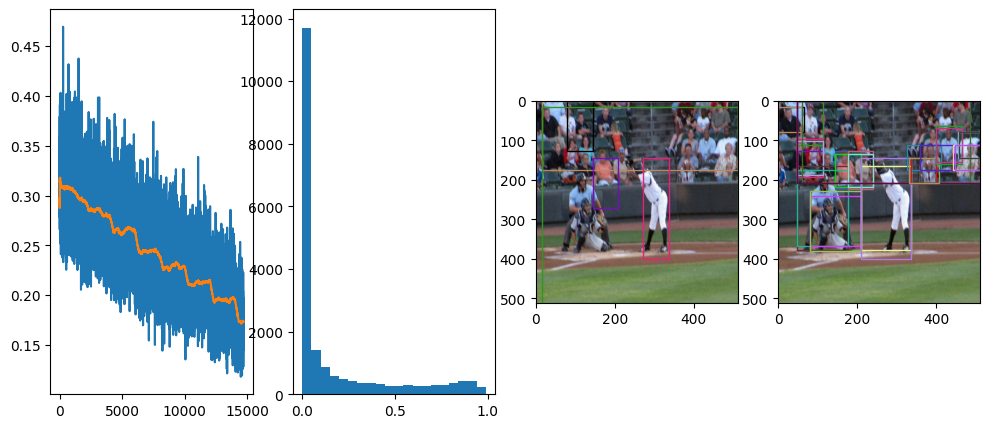

Epoch: 0, step: 14850, last loss: 0.19292806088924408, num_ex: 4,     max pred iou: 0.9960079193115234,     mean pred iou: 0.032746292650699615     count highs: 96


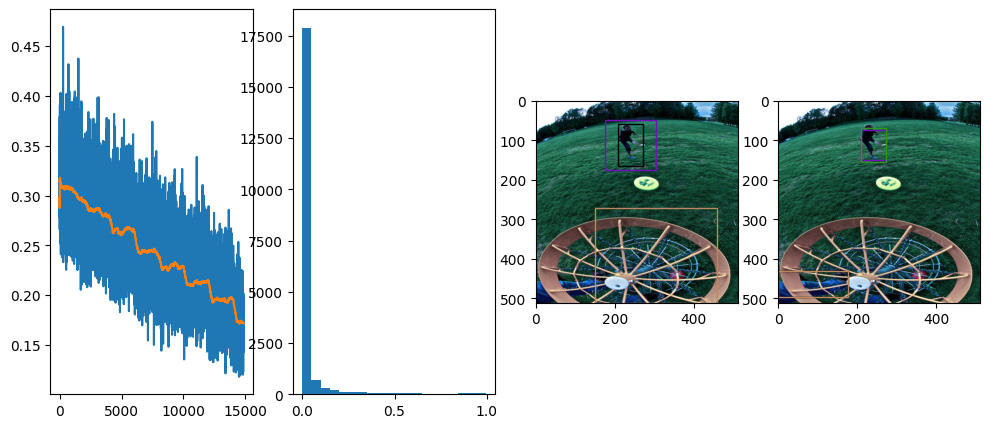

Epoch: 0, step: 15000, last loss: 0.1715313047170639, num_ex: 30,     max pred iou: 0.998578667640686,     mean pred iou: 0.09508353471755981     count highs: 355


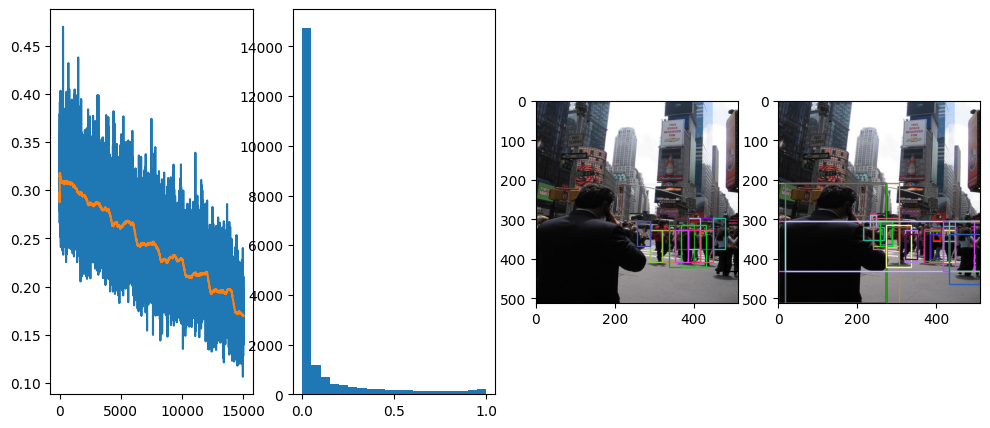

Epoch: 0, step: 15150, last loss: 0.154477059841156, num_ex: 2,     max pred iou: 0.9996141195297241,     mean pred iou: 0.03114119917154312     count highs: 66


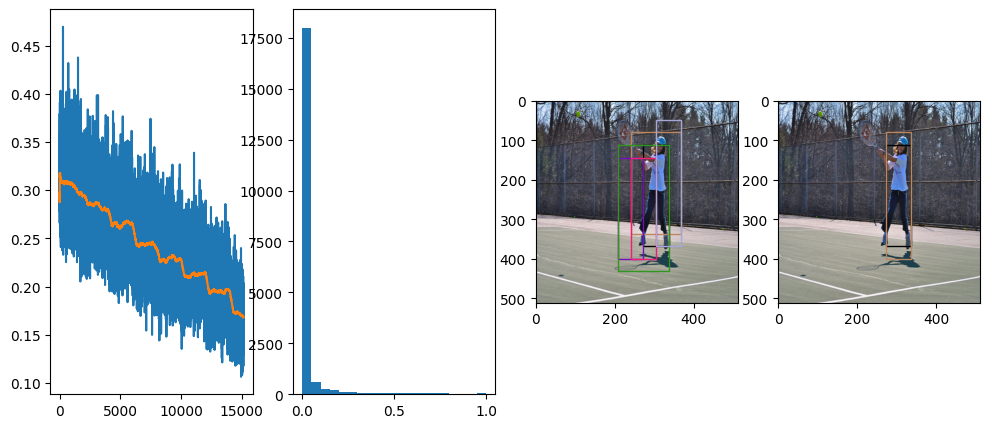

Epoch: 0, step: 15300, last loss: 0.20179925858974457, num_ex: 2,     max pred iou: 0.9993166923522949,     mean pred iou: 0.0439220555126667     count highs: 129


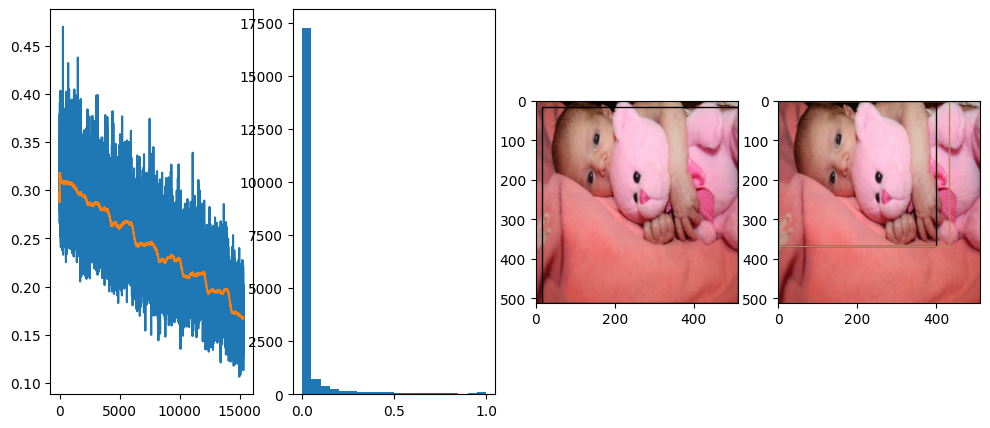

Epoch: 0, step: 15450, last loss: 0.15412217378616333, num_ex: 1,     max pred iou: 0.9921143054962158,     mean pred iou: 0.04381052404642105     count highs: 51


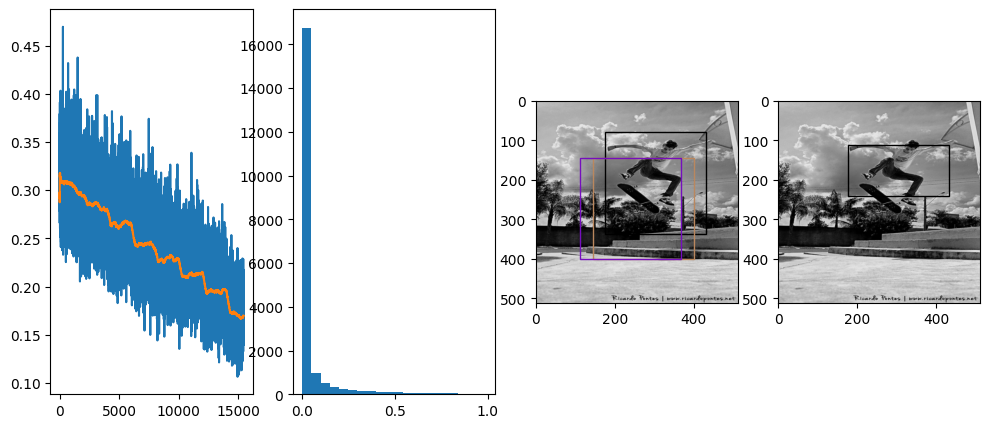

Epoch: 0, step: 15600, last loss: 0.1718314290046692, num_ex: 2,     max pred iou: 0.9990826845169067,     mean pred iou: 0.03674899786710739     count highs: 191


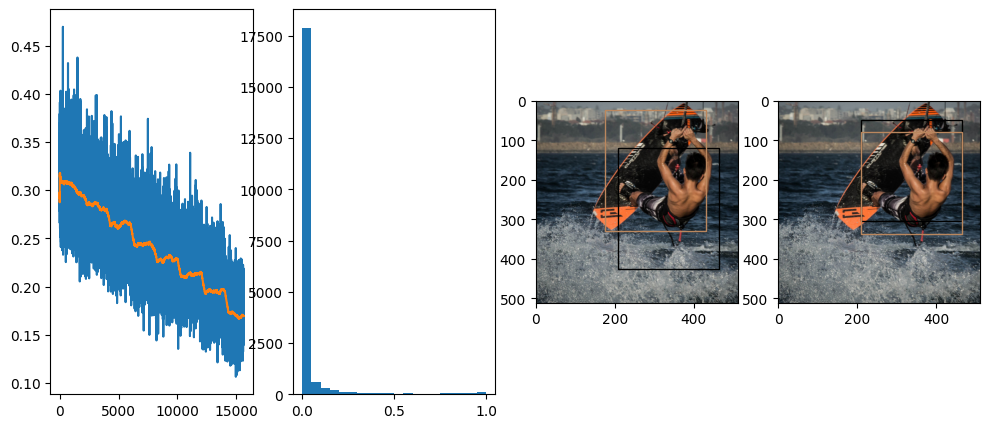

Epoch: 0, step: 15750, last loss: 0.15265220403671265, num_ex: 2,     max pred iou: 0.9915879368782043,     mean pred iou: 0.030172599479556084     count highs: 44


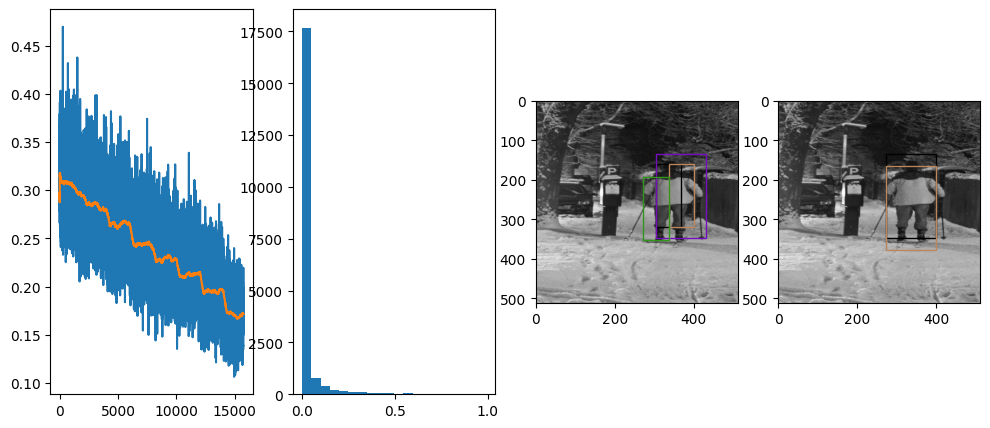

Epoch: 0, step: 15900, last loss: 0.15614040195941925, num_ex: 6,     max pred iou: 0.9956604838371277,     mean pred iou: 0.04094899445772171     count highs: 80


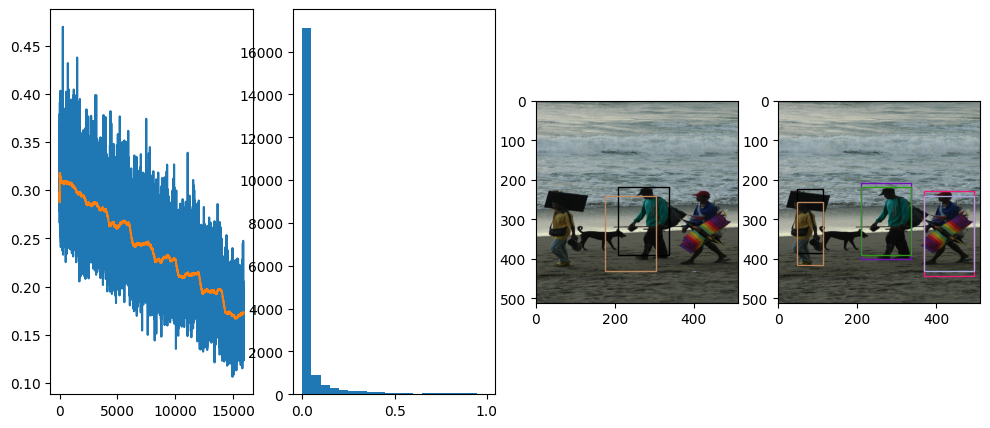

Epoch: 0, step: 16050, last loss: 0.13898324966430664, num_ex: 2,     max pred iou: 0.9966593980789185,     mean pred iou: 0.02739221230149269     count highs: 60


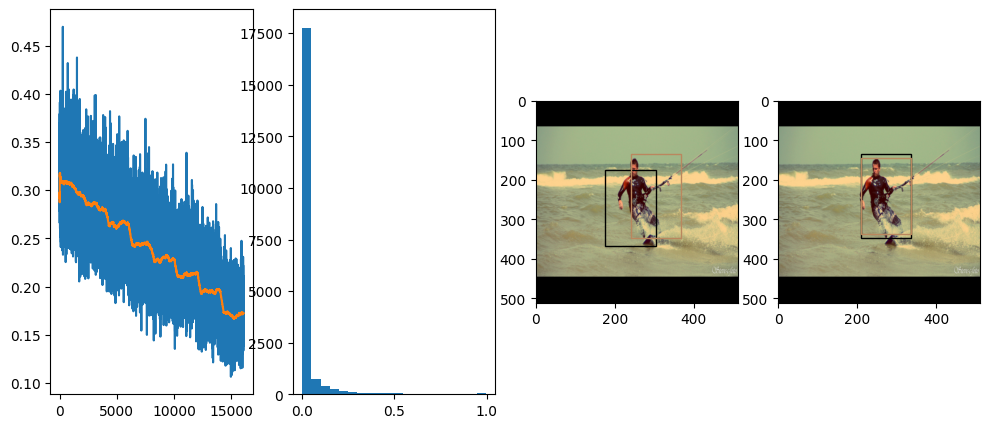

Epoch: 0, step: 16200, last loss: 0.17881612479686737, num_ex: 2,     max pred iou: 0.9961114525794983,     mean pred iou: 0.02198028936982155     count highs: 63


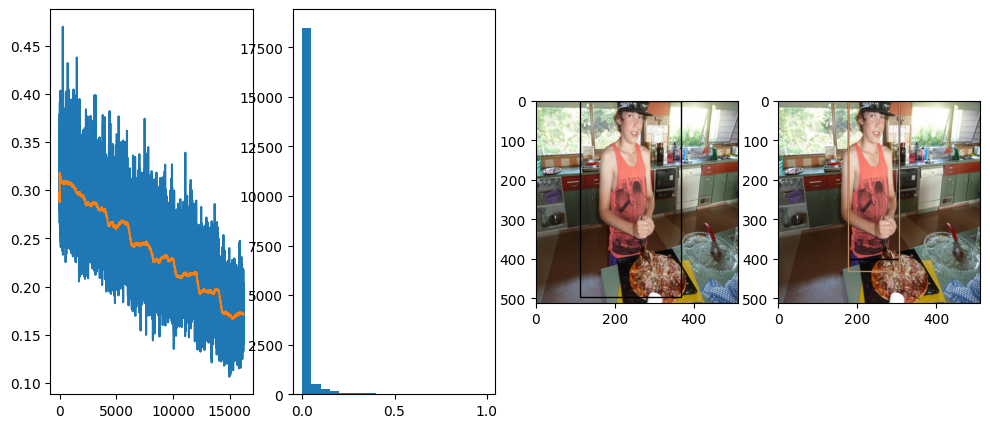

KeyboardInterrupt: 

In [10]:
epochs = 10000
losses = []
step = 0
step_show = 150
converted_anchors = convert_bbox(possible_anchors)
torch.cuda.empty_cache()
#metrics = [BinaryAccuracy(), ]
for epoch in range(epochs):
    for data in dataloader:
        optimizer.zero_grad()
        loss = 0
        image_data = data['images'].to(device)
        temp_bs = len(image_data)
        bboxs = data['bboxs']
        converted_bboxs = convert_bbox(bboxs)
        img_ids = data['img_ids']
    
        ones, zeros = generate_target_iou_per_anchor(converted_anchors, converted_bboxs, img_ids, temp_bs)    

        rpn_output, _ = model(image_data)

        ones_output = rpn_output[ones]
        zeros_output = rpn_output[zeros]
        zeros_select = torch.multinomial(zeros_output - zeros_output.min(), len(ones_output) * 2 + len(anchors) * 2)
        #zeros_select = torch.randint(0, 
        #                             zeros_output.numel(), 
        #                             (len(ones_output) * 2 + len(anchors) * 2, )#ones_output.shape
        #                            )
        zeros_output = zeros_output[zeros_select]

        if len(ones_output)>0:
            loss += loss_fn_rpn(ones_output, torch.ones_like(ones_output))
        if len(zeros_output)>0:
            loss += loss_fn_rpn(zeros_output, torch.zeros_like(zeros_output))
        loss /= (ones_output.numel() + zeros_output.numel())
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        if step % step_show == 0:
            #val_data = next(val_iter)
            #with torch.no_grad():
            #    val_image_data = val_data['images'].to(device)
            #    val_rpn_output, _ = model(val_image_data)
            print_log(rpn_output, epoch, step, loss, bboxs, image_data,
                     ones, zeros, ones_output, zeros_output)
        step += 1

In [11]:
torch.save(model.state_dict(), "model_weights.pth")

In [12]:
torch.save(optimizer.state_dict(), "optimizer_weights.pth")

In [13]:
torch.save(scheduler.state_dict(), "scheduler_weights.pth")

In [7]:
model.load_state_dict(torch.load("model_weights.pth"))
optimizer.load_state_dict(torch.load("optimizer_weights.pth"))
scheduler.load_state_dict(torch.load("scheduler_weights.pth"))